In [27]:
import torch 
import torch.nn as nn 
from torchvision import datasets, transforms, models 
from torch.utils.data import DataLoader, random_split 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [18]:
if torch.cuda.is_available():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("GPU name:", torch.cuda.get_device_name(0))
    print("GPU count:", torch.cuda.device_count())

GPU name: NVIDIA GeForce GTX 1660 Ti
GPU count: 1


# IMPORT DATA

In [19]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder("./train", transform=transform)

# PREPROCESSING

### E. CONSTRUCT A NEW DATASET FOR CLASSIFICATION WITH 2 CLASSES: ORIGINAL AND FAKE.

In [20]:
val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Classes:", full_dataset.classes)

Classes: ['generated', 'real']


# F. CONSTRUCT AND TRAIN A DEEP LEARNING MODEL

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [22]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

EPOCHS = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):

    # TRAINING
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # VALIDATION
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch 1/50 | Train Loss: 5.9885 | Train Acc: 0.8814 | Val Loss: 0.9581 | Val Acc: 0.9643
Epoch 2/50 | Train Loss: 1.5650 | Train Acc: 0.9809 | Val Loss: 0.8013 | Val Acc: 0.9745
Epoch 3/50 | Train Loss: 1.5001 | Train Acc: 0.9758 | Val Loss: 0.4897 | Val Acc: 0.9796
Epoch 4/50 | Train Loss: 1.0099 | Train Acc: 0.9872 | Val Loss: 0.4805 | Val Acc: 0.9796
Epoch 5/50 | Train Loss: 0.8752 | Train Acc: 0.9885 | Val Loss: 0.2806 | Val Acc: 0.9847
Epoch 6/50 | Train Loss: 0.8396 | Train Acc: 0.9885 | Val Loss: 0.6596 | Val Acc: 0.9796
Epoch 7/50 | Train Loss: 1.1005 | Train Acc: 0.9821 | Val Loss: 0.2215 | Val Acc: 0.9847
Epoch 8/50 | Train Loss: 0.7488 | Train Acc: 0.9911 | Val Loss: 0.2159 | Val Acc: 0.9847
Epoch 9/50 | Train Loss: 0.7935 | Train Acc: 0.9923 | Val Loss: 0.7351 | Val Acc: 0.9745
Epoch 10/50 | Train Loss: 0.5958 | Train Acc: 0.9923 | Val Loss: 0.3335 | Val Acc: 0.9847
Epoch 11/50 | Train Loss: 0.5218 | Train Acc: 0.9923 | Val Loss: 0.4044 | Val Acc: 0.9847
Epoch 12/50 | Train

# G. PLOTTING

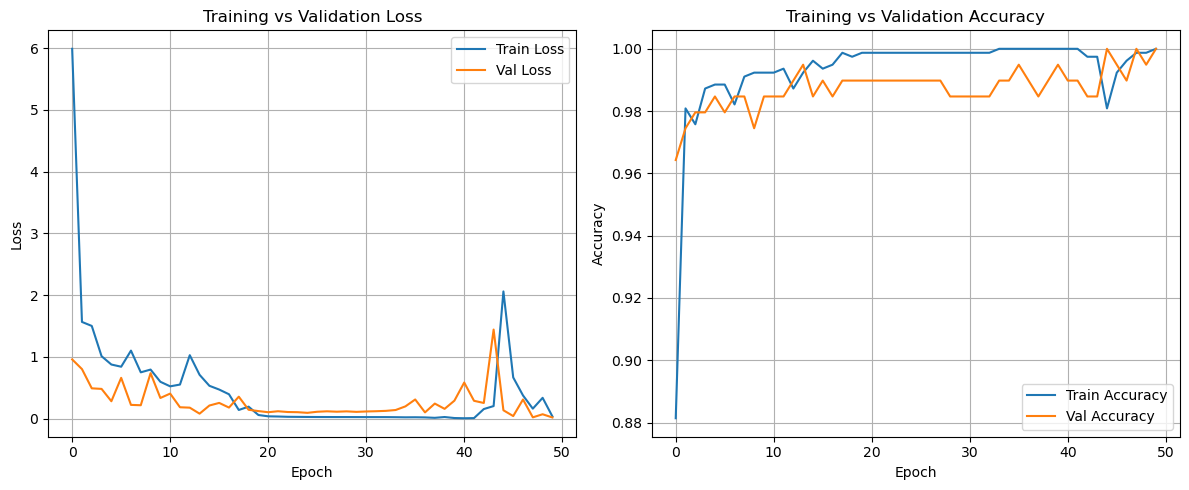

In [23]:
plt.figure(figsize=(12, 5))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**1. INITIAL PHASE (EPOCH 1 → 10)** <br>
<p>Both training loss and validation loss drops sharply from high values indicating the model is successfully learning patterns, and no sign overfitting. </p>

**2. MID TRAINING (EPOCH 10 → 50)** <br>
<p>Training and validation from both accuracy and loss reaches its best peak indicating model can differentiate between generated and real 100% of the time</p>

**IMPROVEMENTS**
Because a 100% accuracy isnt good, we might try to add regularization and adjust lr.

# H. HYPERPARAMATER TUNING

In [ ]:
class CNN_TUNED(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),   
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),    
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),    
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.BatchNorm1d(256),   
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [ ]:
model = CNN_TUNED().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

EPOCHS = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# EARLY STOP
best_val_loss = float('inf')
patience = 10
patience_counter = 0
best_model_state = None

for epoch in range(EPOCHS):

    # TRAINING
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # VALIDATION
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    # EARLY STOPPING
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict() 
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(best_model_state)


Epoch 1/100 | Train Loss: 2.5294 | Train Acc: 0.9694 | Val Loss: 7.5470 | Val Acc: 0.5204
Epoch 2/100 | Train Loss: 0.7320 | Train Acc: 0.9923 | Val Loss: 1.7885 | Val Acc: 0.8827
Epoch 3/100 | Train Loss: 0.5351 | Train Acc: 0.9962 | Val Loss: 0.2084 | Val Acc: 0.9898
Epoch 4/100 | Train Loss: 0.5593 | Train Acc: 0.9936 | Val Loss: 0.1835 | Val Acc: 0.9898
Epoch 5/100 | Train Loss: 0.4547 | Train Acc: 0.9923 | Val Loss: 0.1329 | Val Acc: 0.9898
Epoch 6/100 | Train Loss: 0.1406 | Train Acc: 0.9987 | Val Loss: 0.0401 | Val Acc: 1.0000
Epoch 7/100 | Train Loss: 0.1176 | Train Acc: 1.0000 | Val Loss: 0.0185 | Val Acc: 1.0000
Epoch 8/100 | Train Loss: 0.0506 | Train Acc: 1.0000 | Val Loss: 0.0109 | Val Acc: 1.0000
Epoch 9/100 | Train Loss: 0.1411 | Train Acc: 1.0000 | Val Loss: 0.0077 | Val Acc: 1.0000
Epoch 10/100 | Train Loss: 0.3130 | Train Acc: 0.9962 | Val Loss: 0.0202 | Val Acc: 1.0000
Epoch 11/100 | Train Loss: 0.1131 | Train Acc: 1.0000 | Val Loss: 0.0922 | Val Acc: 0.9898
Epoch 12

<All keys matched successfully>

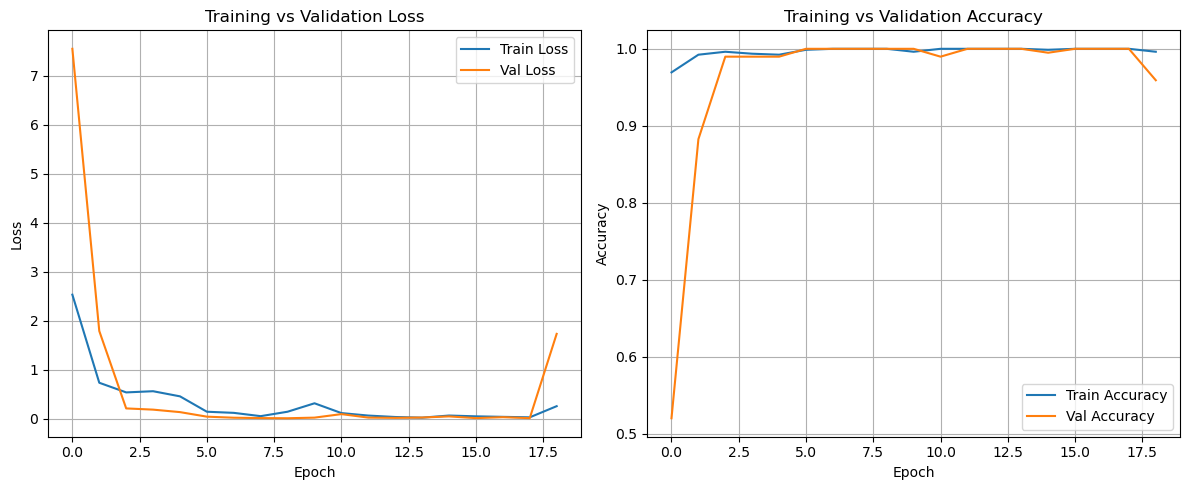

In [ ]:
plt.figure(figsize=(12, 5))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# I. TESTING AND METRICS

In [28]:
test_dataset = datasets.ImageFolder("./test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Test classes:", test_dataset.classes)

Test classes: ['generated', 'real']


In [29]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())


In [30]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

   generated       1.00      1.00      1.00        10
        real       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



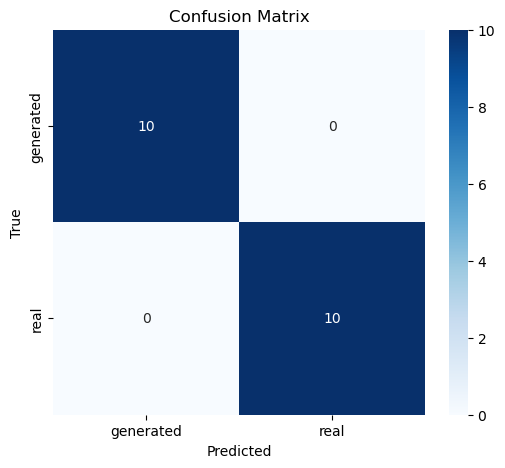

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


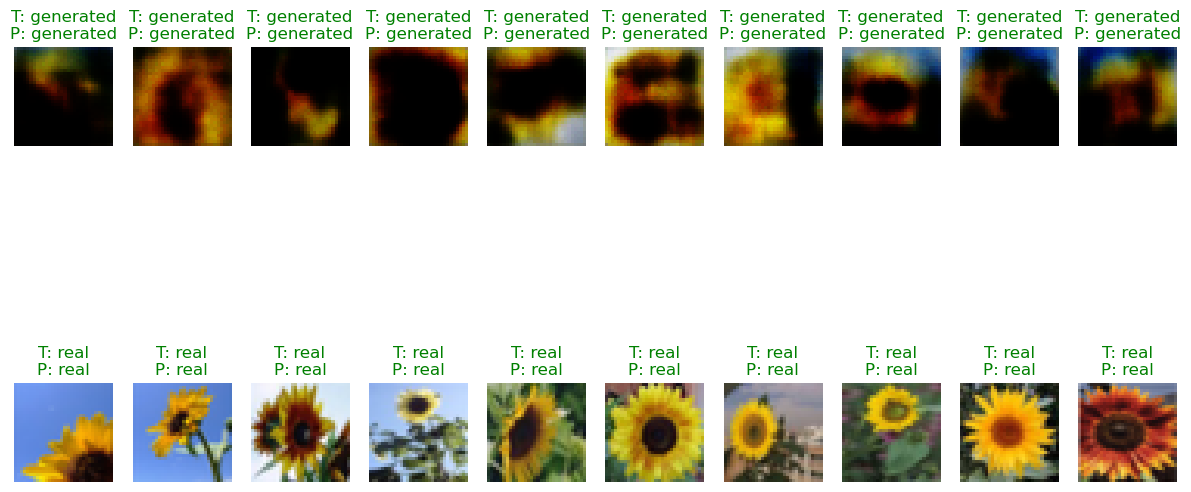

In [ ]:
import matplotlib.pyplot as plt

def show_predictions(model, loader, class_names, num_images=10):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu()

            for i in range(len(imgs)):
                if images_shown >= num_images:
                    return

                plt.subplot(2, num_images//2, images_shown+1)
                plt.imshow(imgs[i].cpu().permute(1, 2, 0))
                plt.axis("off")

                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]

                color = "green" if true_label == pred_label else "red"
                plt.title(f"T: {true_label}\nP: {pred_label}", color=color)

                images_shown += 1
                
show_predictions(model, test_loader, test_dataset.classes, num_images=20)
